#### Probelm statement

Given the appliance usage, outside temp and relative humidity today, predict the appliance usage for tomorrow 

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Flatten,ConvLSTM2D,Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.grid'] = False

In [3]:
df  = pd.read_csv('energydata_complete.csv')
df.head(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [35]:
df.tail(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19732,2016-05-27 17:40:00,270,10,25.5,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.5,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.5,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [34]:
df.shape

(19735, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [10]:
#convert date to timestamp format
df['date'] = pd.to_datetime(df['date'])

In [12]:
df[['date','T_out', 'RH_2', 'Appliances','lights']].head(3)

,date,T_out,RH_2,Appliances,lights
0,2016-01-11 17:00:00,6.600000,44.790000,60,30
1,2016-01-11 17:10:00,6.483333,44.722500,60,30
2,2016-01-11 17:20:00,6.366667,44.626667,50,30


<Axes: xlabel='date'>

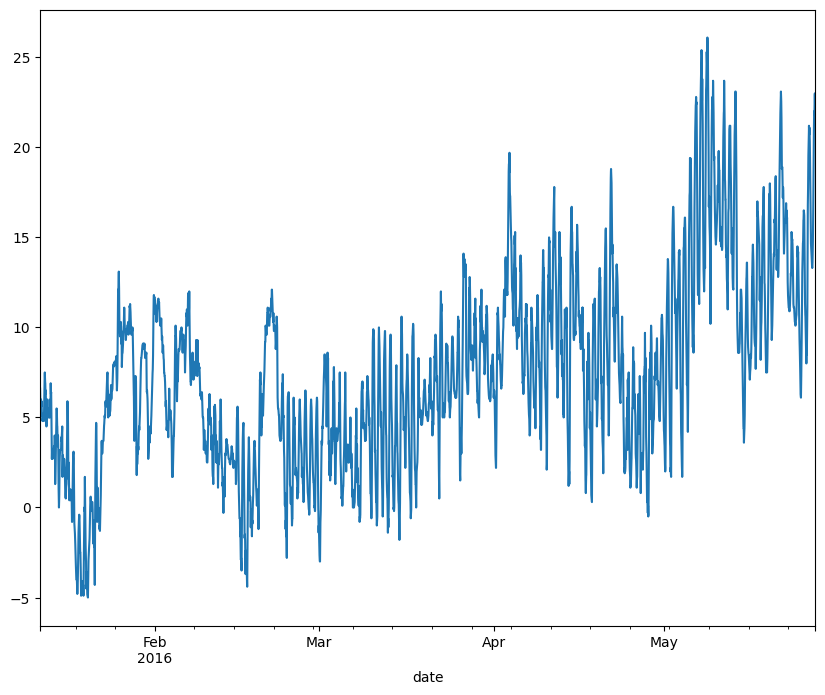

In [13]:
df.set_index('date')['T_out'].plot()

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

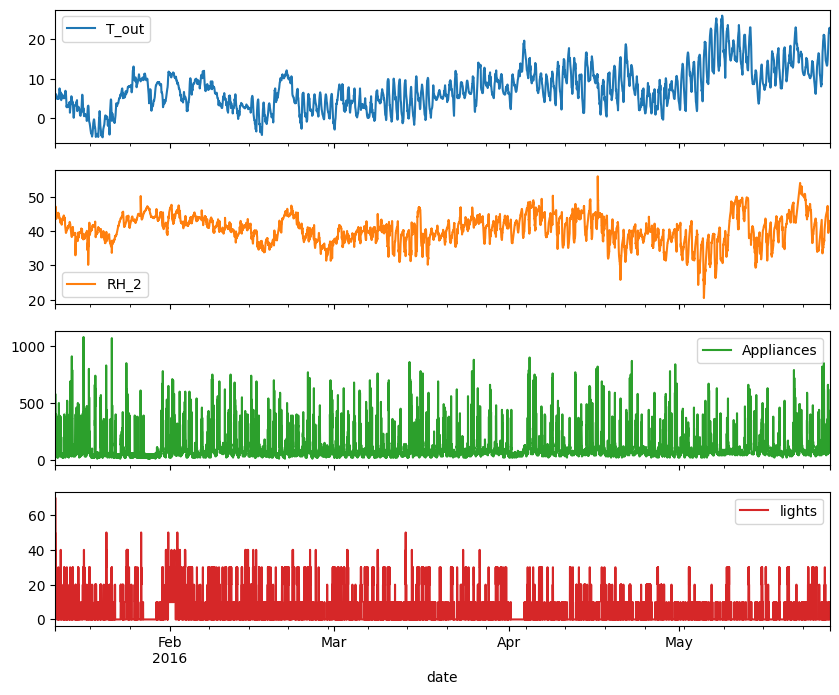

In [14]:
df.set_index('date')[['T_out', 'RH_2', 'Appliances','lights']].plot(subplots=True)

In [15]:
df.count()

date           19735
Appliances     19735
lights         19735
T1             19735
RH_1           19735
T2             19735
RH_2           19735
T3             19735
RH_3           19735
T4             19735
RH_4           19735
T5             19735
RH_5           19735
T6             19735
RH_6           19735
T7             19735
RH_7           19735
T8             19735
RH_8           19735
T9             19735
RH_9           19735
T_out          19735
Press_mm_hg    19735
RH_out         19735
Windspeed      19735
Visibility     19735
Tdewpoint      19735
rv1            19735
rv2            19735
dtype: int64

#### Data preparation for predicting single output

In [20]:
#convert features and target to list to use it in timeseries generator
features=df[['Appliances','T_out', 'RH_2']].to_numpy().tolist() #as there are more than one columns, first convert to numpy and then to list
target=df['Appliances'].tolist()
     

In [23]:
#features = [[round(val, 3) for val in sublist] for sublist in features]
features[:10]

[[60.0, 6.6, 44.79],
 [60.0, 6.48333333333333, 44.7225],
 [50.0, 6.36666666666667, 44.6266666666667],
 [50.0, 6.25, 44.59],
 [60.0, 6.133333333333329, 44.53],
 [50.0, 6.01666666666667, 44.5],
 [60.0, 5.9, 44.5],
 [60.0, 5.91666666666667, 44.5],
 [60.0, 5.93333333333333, 44.433333333333294],
 [70.0, 5.95, 44.4]]

In [24]:
target[:10]

[60, 60, 50, 50, 60, 50, 60, 60, 60, 70]

If you wanna predict tomorrows output (target), data till today becomes the input(feature)

In [25]:
# generating sequences of data using timeseries generator

ts_generator = TimeseriesGenerator(features,target,length = 6,sampling_rate=1,batch_size=1)

In [27]:
ts_generator[0] #outputs batches with size 6 (ie first 6 data will be feature and the 7th data will be target)

(array([[[60.        ,  6.6       , 44.79      ],
         [60.        ,  6.48333333, 44.7225    ],
         [50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ]]]),
 array([60]))

In [28]:
ts_generator[1]

(array([[[60.        ,  6.48333333, 44.7225    ],
         [50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ]]]),
 array([60]))

In [29]:
ts_generator[2]

(array([[[50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ],
         [60.        ,  5.91666667, 44.5       ]]]),
 array([60]))

In [30]:
ts_generator[3]

(array([[[50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ],
         [60.        ,  5.91666667, 44.5       ],
         [60.        ,  5.93333333, 44.43333333]]]),
 array([70]))

In [32]:
len(ts_generator) #as batch size = 1

19729

Input - 1,2,3,4,5,6,7,8,9

Sliding window (window size 3, stride 1) - 1,2,3    2,3,4   4,5,6

Sliding window (window size 3, stride 2) - 1,2,3    3,4,5   7,8,9

Tumbling window (Window size 3)   - 1,2,3   4,5,6   7,8,9    # no overlapping


In [36]:
#time series generator with sliding window with stride 2
ts_generator = TimeseriesGenerator(features, target, length=6, sampling_rate=1, batch_size=1, stride=2)

In [37]:
len(ts_generator)

9865

In [38]:
ts_generator[1]

(array([[[50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ],
         [60.        ,  5.91666667, 44.5       ]]]),
 array([60]))

In [39]:
ts_generator[2]

(array([[[60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ],
         [60.        ,  5.9       , 44.5       ],
         [60.        ,  5.91666667, 44.5       ],
         [60.        ,  5.93333333, 44.43333333],
         [70.        ,  5.95      , 44.4       ]]]),
 array([230]))

#### Data preparation for predicting multiple outputs

In [42]:
#making target variable

pd.concat([df['Appliances'],df['Appliances'].shift(-1),df['Appliances'].shift(-2)],axis=1)


,Appliances,Appliances,Appliances
0,60,60.0,50.0
1,60,50.0,50.0
2,50,50.0,60.0
3,50,60.0,50.0
4,60,50.0,60.0
...,...,...,...
19730,100,90.0,270.0
19731,90,270.0,420.0
19732,270,420.0,430.0
19733,420,430.0,NaN


In [47]:
multi_target = pd.concat([df['Appliances'],df['Appliances'].shift(-1),df['Appliances'].shift(-2)],axis=1).dropna().to_numpy().tolist()
#dropna as the last two columns have na as a result of shifting

In [48]:
multi_target[0:5]

[[60.0, 60.0, 50.0],
 [60.0, 50.0, 50.0],
 [50.0, 50.0, 60.0],
 [50.0, 60.0, 50.0],
 [60.0, 50.0, 60.0]]

In [49]:
features

[[60.0, 6.6, 44.79],
 [60.0, 6.48333333333333, 44.7225],
 [50.0, 6.36666666666667, 44.6266666666667],
 [50.0, 6.25, 44.59],
 [60.0, 6.133333333333329, 44.53],
 [50.0, 6.01666666666667, 44.5],
 [60.0, 5.9, 44.5],
 [60.0, 5.91666666666667, 44.5],
 [60.0, 5.93333333333333, 44.433333333333294],
 [70.0, 5.95, 44.4],
 [230.0, 5.96666666666667, 44.4],
 [580.0, 5.98333333333333, 44.4],
 [430.0, 6.0, 44.4],
 [250.0, 6.0, 45.1],
 [100.0, 6.0, 45.83333333333329],
 [100.0, 6.0, 46.7566666666667],
 [90.0, 6.0, 47.223333333333294],
 [70.0, 6.0, 47.05666666666671],
 [80.0, 6.0, 46.33],
 [140.0, 6.0, 46.0266666666667],
 [120.0, 6.0, 45.7225],
 [190.0, 6.0, 45.53],
 [110.0, 6.0, 45.223333333333294],
 [110.0, 6.0, 44.963333333333296],
 [110.0, 6.0, 44.76],
 [110.0, 5.93333333333333, 44.76],
 [100.0, 5.86666666666667, 45.09],
 [100.0, 5.8, 45.1633333333333],
 [100.0, 5.73333333333333, 45.06],
 [100.0, 5.66666666666667, 44.933333333333294],
 [110.0, 5.6, 44.6333333333333],
 [400.0, 5.65, 44.36],
 [400.0, 

In [50]:
#time series generator with tumbling window 
ts_generator = TimeseriesGenerator(features[:-2], multi_target, length=6, sampling_rate=1, batch_size=1, stride=6)
#features[:-2] as the last two rows of target data which has nan values are removed


In [51]:
ts_generator[0]

(array([[[60.        ,  6.6       , 44.79      ],
         [60.        ,  6.48333333, 44.7225    ],
         [50.        ,  6.36666667, 44.62666667],
         [50.        ,  6.25      , 44.59      ],
         [60.        ,  6.13333333, 44.53      ],
         [50.        ,  6.01666667, 44.5       ]]]),
 array([[60., 60., 60.]]))

In [52]:
ts_generator[1] #here after 6  feature inputs the next three data is considered as target

(array([[[ 60.        ,   5.9       ,  44.5       ],
         [ 60.        ,   5.91666667,  44.5       ],
         [ 60.        ,   5.93333333,  44.43333333],
         [ 70.        ,   5.95      ,  44.4       ],
         [230.        ,   5.96666667,  44.4       ],
         [580.        ,   5.98333333,  44.4       ]]]),
 array([[430., 250., 100.]]))

Here, multiple o/ps are predicted with a tumbling window size of 6 ie no overlapping of data

#### Modelling

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

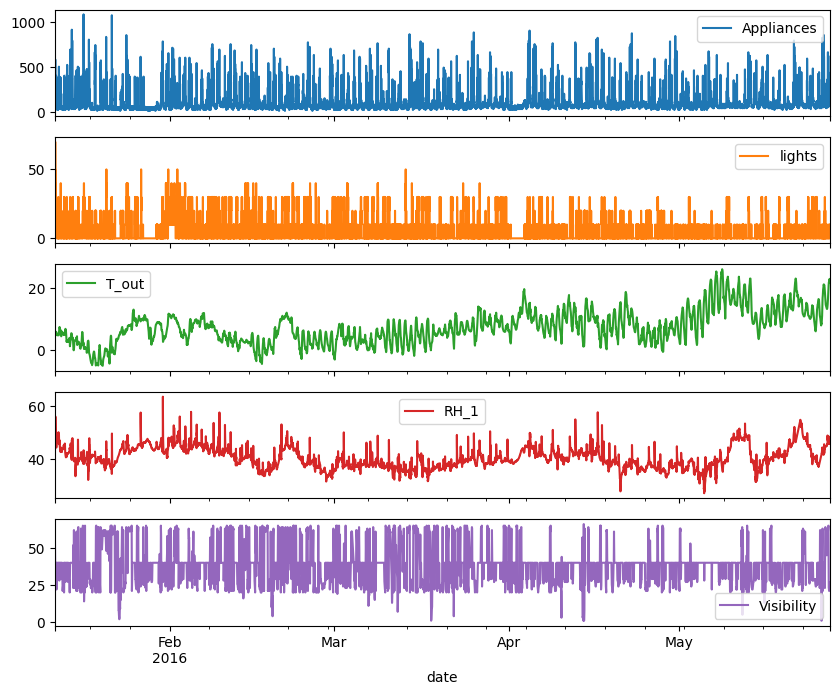

In [53]:
df.set_index('date')[['Appliances', 'lights','T_out', 'RH_1', 'Visibility']].plot(subplots=True)

In [54]:
df_input=df[['Appliances','T_out', 'RH_1', 'Visibility']]
df_input

,Appliances,T_out,RH_1,Visibility
0,60,6.600000,47.596667,63.000000
1,60,6.483333,46.693333,59.166667
2,50,6.366667,46.300000,55.333333
3,50,6.250000,46.066667,51.500000
4,60,6.133333,46.333333,47.666667
...,...,...,...,...
19730,100,22.733333,46.560000,23.666667
19731,90,22.600000,46.500000,24.500000
19732,270,22.466667,46.596667,25.333333
19733,420,22.333333,46.990000,26.166667


In [55]:
df_input.describe()

,Appliances,T_out,RH_1,Visibility
count,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,7.411665,40.259739,38.330834
std,102.524891,5.317409,3.979299,11.794719
min,10.000000,-5.000000,27.023333,1.000000
25%,50.000000,3.666667,37.333333,29.000000
50%,60.000000,6.916667,39.656667,40.000000
75%,100.000000,10.408333,43.066667,40.000000
max,1080.000000,26.100000,63.360000,66.000000


In [56]:

df_input.query("Appliances > 500")

,Appliances,T_out,RH_1,Visibility
11,580,5.983333,46.396667,40.000000
314,520,2.900000,41.530000,36.333333
392,550,2.033333,43.433333,40.000000
393,690,2.100000,43.766667,40.000000
394,620,2.166667,43.693333,40.000000
...,...,...,...,...
19586,600,20.833333,44.066667,40.000000
19587,520,20.900000,43.366667,40.000000
19684,580,15.900000,47.226667,61.000000
19685,660,16.100000,47.693333,61.000000


In [58]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [61]:
type(data_scaled),data_scaled

(numpy.ndarray,
 array([[0.04672897, 0.37299035, 0.56618659, 0.95384615],
        [0.04672897, 0.36923901, 0.54132648, 0.89487179],
        [0.03738318, 0.36548767, 0.53050179, 0.83589744],
        ...,
        [0.24299065, 0.88317256, 0.53866618, 0.37435897],
        [0.38317757, 0.87888532, 0.54949087, 0.38717949],
        [0.39252336, 0.87459807, 0.53875791, 0.4       ]]))

In [62]:
features = data_scaled
target = data_scaled[:,0]

In [63]:
target

array([0.04672897, 0.04672897, 0.03738318, ..., 0.24299065, 0.38317757,
       0.39252336])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)
# for LSTM models time is not given as input where as for fbprophet models time is also given as input

In [67]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15788, 4), (3947, 4), (15788,), (3947,))

In [68]:
#this is th crux of timeseries model. ie converting a forecasting problem into supervised learning
win_length=720 #this implies 5 days of data as input and predicts the 6th day appliance data
batch_size=32
num_features=4
train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
     

In [69]:
train_generator[0]

(array([[[0.04672897, 0.37299035, 0.56618659, 0.95384615],
         [0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         ...,
         [0.06542056, 0.25241158, 0.31584258, 0.79230769],
         [0.05607477, 0.23901393, 0.31309054, 0.72820513],
         [0.06542056, 0.22561629, 0.31107238, 0.66410256]],
 
        [[0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         ...,
         [0.05607477, 0.23901393, 0.31309054, 0.72820513],
         [0.06542056, 0.22561629, 0.31107238, 0.66410256],
         [0.06542056, 0.21221865, 0.30923768, 0.6       ]],
 
        [[0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         [0.04672897, 0.35798499, 0.53141914, 0.71794872],
         ...,
         [0.06542056, 0.22561629, 0.31107238, 0.66410256],
        

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape= (win_length, num_features), activation='relu',return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 128)          68096     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 117569 (459.25 KB)
Trainable params: 117569 (459.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2, mode='min')
history = model.fit_generator(train_generator, epochs=50,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

C:\Users\saras\AppData\Local\Temp\ipykernel_3832\3729785562.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=50,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])


Epoch 1/50


471/471 [==============================] - 356s 749ms/step - loss: 0.0075 - mean_absolute_error: 0.0471 - val_loss: 0.0053 - val_mean_absolute_error: 0.0489
Epoch 2/50
471/471 [==============================] - 363s 771ms/step - loss: 0.0055 - mean_absolute_error: 0.0377 - val_loss: 0.0037 - val_mean_absolute_error: 0.0379
Epoch 3/50
471/471 [==============================] - 398s 845ms/step - loss: 0.0042 - mean_absolute_error: 0.0324 - val_loss: 0.0035 - val_mean_absolute_error: 0.0348
Epoch 4/50
471/471 [==============================] - 383s 812ms/step - loss: 0.0041 - mean_absolute_error: 0.0309 - val_loss: 0.0035 - val_mean_absolute_error: 0.0352
Epoch 5/50
471/471 [==============================] - 359s 762ms/step - loss: 0.0041 - mean_absolute_error: 0.0310 - val_loss: 0.0034 - val_mean_absolute_error: 0.0327
Epoch 6/50
471/471 [==============================] - 390s 828ms/step - loss: 0.0040 - mean_absolute_error: 0.0306 - val_loss: 0.0034 - val_mean_absolute_erro

In [81]:
from tensorflow.keras.models import load_model
model.save('multivariate_best.h5')

AttributeError: 'NoneType' object has no attribute 'save'

In [82]:
model = load_model('multivariate_best.h5')

In [83]:
model.evaluate_generator(test_generator, verbose=0)  

C:\Users\saras\AppData\Local\Temp\ipykernel_3832\748299794.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator, verbose=0)


[0.003305356251075864, 0.03323877975344658]

In [84]:
predictions=model.predict_generator(test_generator)

C:\Users\saras\AppData\Local\Temp\ipykernel_3832\2533966764.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(test_generator)


In [97]:
predictions.shape # it uses the first 720 to predict the next data

(3227, 1)

In [86]:
predictions

array([[0.08138476],
       [0.10129745],
       [0.12557092],
       ...,
       [0.10490961],
       [0.26552248],
       [0.26545662]], dtype=float32)

In [87]:
y_test

array([0.3364486 , 0.54205607, 0.28971963, ..., 0.24299065, 0.38317757,
       0.39252336])

In [88]:
X_test

array([[0.3364486 , 0.34297964, 0.30923768, 0.6       ],
       [0.54205607, 0.34726688, 0.3055683 , 0.6       ],
       [0.28971963, 0.35155413, 0.30455921, 0.6       ],
       ...,
       [0.24299065, 0.88317256, 0.53866618, 0.37435897],
       [0.38317757, 0.87888532, 0.54949087, 0.38717949],
       [0.39252336, 0.87459807, 0.53875791, 0.4       ]])

In [89]:
X_test[:,1:][win_length:] # first 720 data is excluded as predictions wouldnt contain it

array([[0.45337621, 0.20851298, 0.6       ],
       [0.47106109, 0.18282726, 0.6       ],
       [0.48874598, 0.18466196, 0.6       ],
       ...,
       [0.88317256, 0.53866618, 0.37435897],
       [0.87888532, 0.54949087, 0.38717949],
       [0.87459807, 0.53875791, 0.4       ]])

In [90]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])],axis=1) 
# dataframe with first column as prediction(not y_test) and subsequent columns from X_test

In [91]:
df_pred

,0,0,1,2
0,0.081385,0.453376,0.208513,0.600000
1,0.101297,0.471061,0.182827,0.600000
2,0.125571,0.488746,0.184662,0.600000
3,0.341084,0.506431,0.193996,0.600000
4,0.148416,0.524116,0.181818,0.600000
...,...,...,...,...
3222,0.104215,0.891747,0.537657,0.348718
3223,0.115621,0.887460,0.536006,0.361538
3224,0.104910,0.883173,0.538666,0.374359
3225,0.265522,0.878885,0.549491,0.387179


In [92]:
rev_trans=scaler.inverse_transform(df_pred) # as inverse transform expects input to have same dimension as that of the input passed to sclaer function
rev_trans

array([[ 97.08169654,   9.1       ,  34.6       ,  40.        ],
       [118.38826679,   9.65      ,  33.66666667,  40.        ],
       [144.36088771,  10.2       ,  33.73333333,  40.        ],
       ...,
       [122.25327872,  22.46666667,  46.59666667,  25.33333333],
       [294.10905361,  22.33333333,  46.99      ,  26.16666667],
       [294.03858006,  22.2       ,  46.6       ,  27.        ]])

In [93]:
df_final = df_input[predictions.shape[0]*-1:]

In [94]:
df_final['App_Pred']=rev_trans[:,0]

C:\Users\saras\AppData\Local\Temp\ipykernel_3832\2704095297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['App_Pred']=rev_trans[:,0]


In [95]:
#comparison between actuals(Appliances) and predicted(App_Pred)
df_final

,Appliances,T_out,RH_1,Visibility,App_Pred
16508,90,9.100000,34.600000,40.000000,97.081697
16509,120,9.650000,33.666667,40.000000,118.388267
16510,390,10.200000,33.733333,40.000000,144.360888
16511,240,10.750000,34.072500,40.000000,374.960394
16512,120,11.300000,33.630000,40.000000,168.805006
...,...,...,...,...,...
19730,100,22.733333,46.560000,23.666667,121.510508
19731,90,22.600000,46.500000,24.500000,133.714096
19732,270,22.466667,46.596667,25.333333,122.253279
19733,420,22.333333,46.990000,26.166667,294.109054


<Axes: >

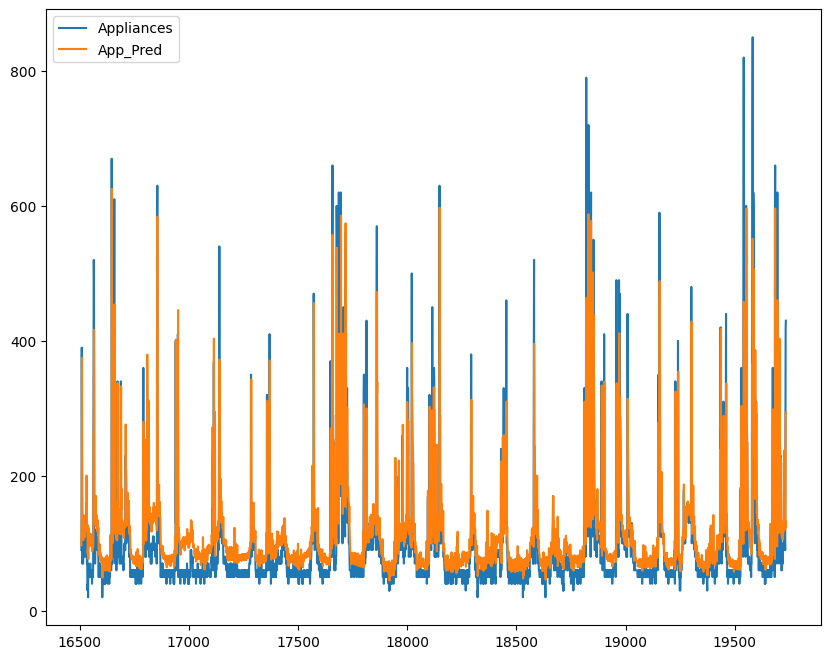

In [96]:
df_final[['Appliances','App_Pred']].plot()

In [113]:
y_test[win_length:].shape, y_test[win_length:]

((3227,),
 array([0.07476636, 0.10280374, 0.35514019, ..., 0.24299065, 0.38317757,
        0.39252336]))

In [110]:
predictions[:,0].shape,predictions[:,0]

((3227,),
 array([0.08138476, 0.10129745, 0.12557092, ..., 0.10490961, 0.26552248,
        0.26545662], dtype=float32))

In [114]:
# calculate root mean squared error

import math
testScore = math.sqrt(mean_squared_error(y_test[win_length:], predictions[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.06 RMSE


The model performance is good as the RMSE is low